In [17]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torch
import numpy as np
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
?FashionMNIST

In [18]:
datadir="data"
train_data = FashionMNIST(root=datadir, train=True, download=True, transform=ToTensor())
test_data = FashionMNIST(root=datadir, train=False, download=True, transform=ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [19]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

        self.first = True
        self.start_weights = {}
        self.end_weights = {}

    def forward(self, x):
        if self.first:
            self.first = False
            self.log_start_weights()

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def log_start_weights(self):
        self.start_weights = {
            "conv1": self.conv1.weight.cpu().detach().numpy(),
            "conv2": self.conv2.weight.cpu().detach().numpy(),
            "fc1": self.fc1.weight.cpu().detach().numpy(),
            "fc2": self.fc2.weight.cpu().detach().numpy(),
        }

    def log_end_weights(self):
        self.end_weights = {
            "conv1": self.conv1.weight.cpu().detach().numpy(),
            "conv2": self.conv2.weight.cpu().detach().numpy(),
            "fc1": self.fc1.weight.cpu().detach().numpy(),
            "fc2": self.fc2.weight.cpu().detach().numpy(),
        }

def train( model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    model.log_end_weights()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [21]:
LR=0.001
GAMMA=0.7
EPOCHS=2
device="cuda"

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LR)


In [22]:


scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293868
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.302377
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.288112
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.283208
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.278955
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.313639
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.288851
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.306035
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301236
Train Epoch: 1 [2880/60000 (5%)]	Loss: 2.293371
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.287654
Train Epoch: 1 [3520/60000 (6%)]	Loss: 2.289837
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.303721
Train Epoch: 1 [4160/60000 (7%)]	Loss: 2.307404
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.288959
Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.276751
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.280452
Train Epoch: 1 [5440/60000 (9%)]	Loss: 2.279994
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.279576
Train Epoch: 1 [6080/60000 (10%)]	Loss: 2.288529
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.27

In [23]:
c1_0 = model.start_weights["conv1"]
c1_1 = model.end_weights["conv1"]


In [24]:
#values_a = np.abs((c1_1 - c1_0).flatten())
values_b = np.abs((c1_1 - c1_0).flatten())

In [25]:
(values_a -values_b).sum()

0.0

In [14]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

(array([113.,  19.,   9.,   6.,   5.,   9.,   3.,   7.,  11.,   6.,   4.,
          1.,   2.,   4.,   1.,   1.,   3.,   1.,   2.,   4.,   3.,   4.,
          0.,   1.,   0.,   0.,   1.,   1.,   3.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   1.,   2.,   5.,   4.,   3.,   3.,
          1.,   5.,   6.,   0.,   1.,   1.,   2.,   0.,   2.,   0.,   1.,
          0.,   2.,   4.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          2.,   0.,   0.,   0.,   0.,   2.,   2.,   1.,   0.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,
          2.]),
 array([0.        , 0.00050827, 0.00101653, 0.0015248 , 0.00203307,
        0.00254134, 0.0030496 , 0.00355787, 0.00406614, 0.00457441,
        0.00508267, 0.00559094, 0.00609921, 0.00660747, 0.00711574,
        0.00762401, 0.00813228, 0.00864054, 0.00914881, 0.00965708,
        0.01016534, 0.01067361, 0.01118188, 0.

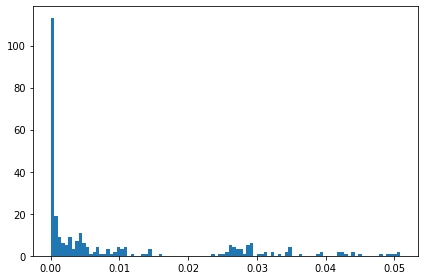

In [16]:
n_bins = 100

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(values_a, bins=n_bins)
